# Cure Algorithm

Here is another implementation of the CURE algorithm using numpy, created by Chu Kun

* Note: This implementation seems to use the data points in order and not randomly.

https://github.com/Kchu/CURE-cluster-python


In [1]:
import numpy as np
import scipy.spatial.distance as distance
import sys

# Returns the distance between two vectors
def dist(vecA, vecB):
    return np.sqrt(np.power(vecA - vecB, 2).sum())

# This class describes the data structure and method of operation for CURE clustering.
class CureCluster:
    def __init__(self, id__, center__):
        self.points = center__
        self.repPoints = center__
        self.center = center__
        self.index = [id__]
        
    # Computes and stores the centroid of this cluster, based on its points
    def computeCentroid(self, clust):
        totalPoints_1 = len(self.index)
        totalPoints_2 = len(clust.index)
        self.center = (self.center*totalPoints_1 + clust.center*totalPoints_2) / (totalPoints_1 + totalPoints_2)
    
    # Computes and stores representative points for this cluster
    def generateRepPoints(self, numRepPoints, alpha):
        tempSet = None
        for i in range(1, numRepPoints+1):
            maxDist = 0
            maxPoint = None
            for p in range(0, len(self.index)):
                if i == 1:
                    minDist = dist(self.points[p,:], self.center)
                else:
                    X = np.vstack([tempSet, self.points[p, :]])
                    tmpDist = distance.pdist(X)
                    minDist = tmpDist.min()
                if minDist >= maxDist:
                    maxDist = minDist
                    maxPoint = self.points[p,:]
            if tempSet is None:
                tempSet = maxPoint
            else:
                tempSet = np.vstack((tempSet, maxPoint))
        for j in range(len(tempSet)):
            if self.repPoints is None:
                self.repPoints = tempSet[j,:] + alpha * (self.center - tempSet[j,:])
            else:
                self.repPoints = np.vstack((self.repPoints, tempSet[j,:] + alpha * (self.center - tempSet[j,:])))

    # Computes and stores distance between this cluster and the other one.
    def distRep(self, clust):
        distRep = float('inf')
        for repA in self.repPoints:
            if type(clust.repPoints[0]) != list:
                repB = clust.repPoints
                distTemp = dist(repA, repB)
                if distTemp < distRep:
                    distRep = distTemp
            else:
                for repB in clust.repPoints:
                    distTemp = dist(repA, repB)
                    if distTemp < distRep:
                        distRep = distTemp
        return distRep

    # Merges this cluster with the given cluster, recomputing the centroid and the representative points.
    def mergeWithCluster(self, clust, numRepPoints, alpha):
        self.computeCentroid(clust)
        self.points = np.vstack((self.points, clust.points))
        self.index = np.append(self.index, clust.index)
        self.repPoints = None
        self.generateRepPoints(numRepPoints, alpha)


In [2]:
# Describe the process of the CURE algorithm
def runCURE(data, numRepPoints, alpha, numDesCluster):

    # Initialization
    Clusters = []
    numCluster = len(data)
    numPts = len(data)
    distCluster = np.ones([len(data), len(data)])
    distCluster = distCluster * float('inf')
    
    for idPoint in range(len(data)):
        newClust = CureCluster(idPoint, data[idPoint,:])
        Clusters.append(newClust)
    
    for row in range(0, numPts):
        for col in range(0, row):
            distCluster[row][col] = dist(Clusters[row].center, Clusters[col].center)
    
    while numCluster > numDesCluster:
        if np.mod(numCluster, 50) == 0:
            print('Cluster count:', numCluster)

        # Find a pair of close clusters
        minIndex = np.where(distCluster == np.min(distCluster))
        minIndex1 = minIndex[0][0]
        minIndex2 = minIndex[1][0]

        # Merge
        Clusters[minIndex1].mergeWithCluster(Clusters[minIndex2], numRepPoints, alpha)
        
        # Update the distCluster matrix
        for i in range(0, minIndex1):
            distCluster[minIndex1, i] = Clusters[minIndex1].distRep(Clusters[i])
        for i in range(minIndex1+1, numCluster):
            distCluster[i, minIndex1] = Clusters[minIndex1].distRep(Clusters[i])
        
        # Delete the merged cluster and its disCluster vector.
        distCluster = np.delete(distCluster, minIndex2, axis=0)
        distCluster = np.delete(distCluster, minIndex2, axis=1)
        del Clusters[minIndex2]
        numCluster = numCluster - 1

    print('Cluster count:', numCluster)
    
    # Generate sample labels
    Label = [0] * numPts
    for i in range(0, len(Clusters)):
        for j in range(0, len(Clusters[i].index)):
            Label[Clusters[i].index[j]] = i + 1

    return Label

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# numRepPoints = 3;  alpha = 0.2;  numDesCluster = 3

# The number of representative points
numRepPoints = 3
# Shrink factor
alpha = 0.2
# Define a desired number of clusters
numDesCluster = 3

data_set = np.loadtxt('./data.txt')
data = data_set[:,0:2]
Label_true = data_set[:,2]
print("Processing...")
Label_pre = runCURE(data, numRepPoints, alpha, numDesCluster)
print("CURE clustering complete\n")


Processing...
Cluster count: 600
Cluster count: 550
Cluster count: 500
Cluster count: 450
Cluster count: 400
Cluster count: 350
Cluster count: 300
Cluster count: 250
Cluster count: 200
Cluster count: 150
Cluster count: 100
Cluster count: 50
Cluster count: 3
CURE clustering complete



NMI = 1.0


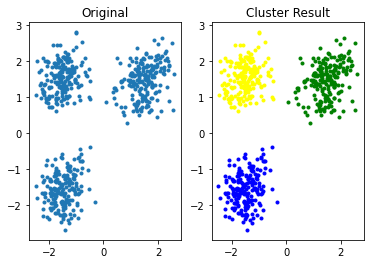

In [4]:
# Compute the NMI
nmi = metrics.v_measure_score(Label_true, Label_pre)
print("NMI =", nmi)

# Plot the Original Data set

plt.subplot(121)
plt.scatter(data_set[:, 0], data_set[:, 1], marker='.')
plt.title("Original")
plt.subplot(122)

# Plot the result

scatterColors = ['black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'brown', 'cyan', 'brown',
                 'chocolate', 'darkgreen', 'darkblue', 'azure', 'bisque']
for i in range(data_set.shape[0]):
    color = scatterColors[Label_pre[i]]
    plt.scatter(data_set[i, 0], data_set[i, 1], marker='.', c=color)
plt.title("Cluster Result")
plt.show()